In [ ]:
!pip install pandas numpy matplotlib scikit-learn plotly


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("../../RibosomeProfiler/sample_data/annotated_read_df_cleaned.csv")

In [ ]:
def create_profile_df(df, transcript_id):
    df_subset = df[df['transcript_id'].str.contains(transcript_id)]
    profile = []
    for g in df_subset.groupby('a_site'):
        profile.append([g[0], g[1].shape[0]])
    for i in range(0, df_subset['a_site'].max() + 1):
        if i not in df_subset['a_site'].values:
            profile.append([i, 0])

    profile = sorted(profile, key=lambda x: x[0])

    profile_df = pd.DataFrame(profile, columns=['a_site', 'count'])
    return profile_df


In [ ]:
def proportion_of_kmer(profile_df, k):
    proportion = []
    count = 0
    for i in range(0, profile_df['a_site'].max()-(k -1), k):
        if i in profile_df['a_site'].values:
            f1 = profile_df[profile_df['a_site'] == i]['count'].values[0]
        else:
            f1 = 0

        if i + 1 in profile_df['a_site'].values:
            f2 = profile_df[profile_df['a_site'] == i + 1]['count'].values[0]
        else:
            f2 = 0

        if i + 2 in profile_df['a_site'].values:
            f3 = profile_df[profile_df['a_site'] == i + 2]['count'].values[0]
        else:
            f3 = 0
            
        if sum([f1, f2, f3]) == 0:
            continue
        count += 1
        p1 = f1 / (f1 + f2 + f3) 
        p2 = f2 / (f1 + f2 + f3)
        p3 = f3 / (f1 + f2 + f3)
        proportion.append([count, p1, p2, p3])
    return proportion


In [ ]:
# get proporitons for each transcript in a merged df

# get top ten occuring transcripts
transcript_ids = df['transcript_id'].value_counts().index.tolist()

merged = pd.DataFrame()

for transcript_id in transcript_ids[:10]:
    profile_df = create_profile_df(df, transcript_id)
    proportion = proportion_of_kmer(profile_df, k=3)
    proportion_df = pd.DataFrame(proportion, columns=['count', 'p1', 'p2', 'p3'])
    proportion_df['transcript_id'] = transcript_id
    merged = pd.concat([merged, proportion_df])


In [ ]:
# k means clustering of p1 and p2
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(merged[['p1', 'p2']])

merged['kmeans_cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_
#plot centroids on p1 vs p2

plt.scatter(merged['p1'], merged['p2'], c=merged['kmeans_cluster'])

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [ ]:
def get_euc_distance_point_to_centroid(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

In [ ]:
get_euc_distance_point_to_centroid(np.array([0, 0]), centroids[2])

In [ ]:
def get_distances_to_centroids(point, centroids):
    distances = []
    for centroid in centroids:
        distances.append(get_euc_distance_point_to_centroid(point, centroid))
    return sorted(distances)

In [ ]:
def assign_point_to_cluster(point, centroids):
    distances = []
    for centroid in centroids:
        distances.append(get_euc_distance_point_to_centroid(point, centroid))
    return np.argmin(distances)

In [ ]:
assign_point_to_cluster(np.array([1, 1]), centroids)

In [ ]:
def get_other_clusters_for_point(point, centroids):
    distances = []
    for centroid in centroids:
        distances.append(get_euc_distance_point_to_centroid(point, centroid))
    return np.argsort(distances)[1:]

In [ ]:
get_other_clusters_for_point(np.array([0, 1]), centroids)

In [ ]:
distances = get_distances_to_centroids(np.array([0, 0]), centroids)
sum(distances[1:])


In [ ]:
# Run DBSCAN on p1 and p2
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = merged[['p1', 'p2']].values
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.25, min_samples=60).fit(X)

labels = db.labels_

merged['dbscan_cluster'] = labels

merged['dbscan_cluster'].value_counts()

# get dbscan centroids
centroids = []
for cluster in merged['dbscan_cluster'].unique():
    centroids.append(merged[merged['dbscan_cluster'] == cluster][['p1', 'p2']].mean().values)

plt.scatter(merged['p1'], merged['p2'], c=merged['dbscan_cluster'])

centroids = np.array(centroids)

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [ ]:
# for given point get sum of distance to furtherst two centroids
def get_sum_of_distances_to_furtherst_two_centroids(point, centroids):
    distances = []
    for centroid in centroids:
        distances.append(get_euc_distance_point_to_centroid(point, centroid))
    return sum(sorted(distances)[1:3])



# Initialize continuous proportions

In [ ]:
# get all combinations of read counts for p1, p2, p3
import itertools

numbers = range(1, 101)

permutations = []
for perm in itertools.permutations(numbers, 3):
    if sum(perm) == 100:
        permutations.append(perm)

read_frame_continuous = {}
for i, perm in enumerate(permutations):
    read_frame_continuous[i] = {0: perm[0], 1: perm[1], 2: perm[2]}

read_frame_continuous_df = pd.DataFrame(read_frame_continuous).T

In [ ]:
# get min distance to nearest centroid
def get_min_distance_to_nearest_centroid(point, centroids):
    distances = []
    for centroid in centroids:
        distances.append(get_euc_distance_point_to_centroid(point, centroid))
    return min(distances)



In [ ]:
# add min distance to nearest centroid to read_frame_continuous_df
read_frame_continuous_df['min_distance_to_nearest_centroid'] = read_frame_continuous_df.apply(lambda x: get_min_distance_to_nearest_centroid(x.values[0], centroids), axis=1)

# plot continuous read frame p1 vs p2
plt.scatter(read_frame_continuous_df[0], read_frame_continuous_df[1], c=read_frame_continuous_df['min_distance_to_nearest_centroid'])

# label axes
plt.xlabel('p1')
plt.ylabel('p2')

# title 
plt.title('p1 vs p2 for all possible read frame combinations colored by min distance to nearest centroid')

In [ ]:
def calculate_frame_bias(f1, f2, f3):
    frames = sorted([f1, f2, f3])
    return 1 - (frames[1]/frames[2])


In [ ]:
def calculate_frame_bias2(f1, f2, f3):
    frames = sorted([f1, f2, f3])
    return frames[2] / sum(frames)

In [ ]:
# add frame bias to read_frame_continuous_df (1-(count of the second highest peak/count of the highest peak))
read_frame_continuous_df['frame_bias'] = read_frame_continuous_df.apply(lambda x: calculate_frame_bias(x.values[0], x.values[1], x.values[2]), axis=1)

# plot continuous read frame p1 vs p2
plt.scatter(read_frame_continuous_df[0], read_frame_continuous_df[1], c=read_frame_continuous_df['frame_bias'])

# label axes
plt.xlabel('p1')
plt.ylabel('p2')

# title
plt.title('p1 vs p2 for all possible read frame combinations colored by frame bias')

In [ ]:
read_frame_continuous_df['frame_bias2'] = read_frame_continuous_df.apply(lambda x: calculate_frame_bias2(x.values[0], x.values[1], x.values[2]), axis=1)

# plot continuous read frame p1 vs p2
plt.scatter(read_frame_continuous_df[0], read_frame_continuous_df[1], c=read_frame_continuous_df['frame_bias2'])

# label axes
plt.xlabel('p1')
plt.ylabel('p2')

# title
plt.title('p1 vs p2 for all possible read frame combinations colored by frame bias2')


In [ ]:
# use plotly to plot p1 vs p2 vs p3 as a ternary scatter plot
import plotly.express as px

fig = px.scatter_ternary(read_frame_continuous_df, a=0, b=1, c=2, color="frame_bias", hover_name="frame_bias", size_max=15)
fig.show()

In [ ]:
fig = px.scatter_ternary(read_frame_continuous_df, a=0, b=1, c=2, color="frame_bias", hover_name="frame_bias2", size_max=15)
fig.show()

In [ ]:
def calculate_distance_ternary_plane(point, target):
    '''
    Calculated distance from point to target in ternary plane (p1, p2, p3)
    Using euclidean distance in 3D cartesian coordinates

    Parameters
    ----------
    point : list
        List of proportions in p1, p2, p3

    target : list
        List of proportions in p1, p2, p3

    Returns 
    -------
    distance : float
        Distance from point to target in ternary plane
    '''
    point = np.array(point)
    target = np.array(target)

    # get vertices of triangle
    vertices = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, 1]])

    # get cartesian coordinates of point
    cartesian_point = np.dot(point, vertices)

    # get cartesian coordinates of target
    cartesian_target = np.dot(target, vertices)

    # calculate distance between cartesian_point and cartesian_target
    distance = np.sqrt(np.sum((cartesian_point - cartesian_target)**2))

    return distance


In [ ]:
def get_cart_point(ternary_point, vertices=[[0.0, 0.0], [1.0, 0.0], [0.5, 1]]):
    point = np.array(ternary_point)
    # get vertices of triangle
    verts= np.array(vertices)

    # get cartesian coordinates of point
    cartesian_point = np.dot(point, verts)
    return cartesian_point

In [ ]:
def calculate_distance_cartesian(cart_point, target):
    '''
    Calculated distance from point to target in ternary plane (p1, p2, p3)
    Using euclidean distance in 3D cartesian coordinates

    Parameters
    ----------
    point : list
        List of proportions in p1, p2, p3

    target : list
        List of proportions in p1, p2, p3

    Returns 
    -------
    distance : float
        Distance from point to target in ternary plane
    '''
    cart_point = np.array(cart_point)
    target = np.array(target)

    # calculate distance between cartesian_point and cartesian_target
    distance = np.sqrt(np.sum((cart_point - target)**2))

    return distance

# Exploring Cartesian Triangle

In [ ]:
#get cartesian points for all points in read_frame_continuous_df
read_frame_continuous_df['cartesian_point'] = read_frame_continuous_df.apply(lambda x: get_cart_point(x.values[0:3]), axis=1)


In [ ]:
A = np.array([0, 0])
B = np.array([100, 0])
C = np.array([50, 100])

read_frame_continuous_df['distance_from_A'] = read_frame_continuous_df.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], A), axis=1)
read_frame_continuous_df['distance_from_B'] = read_frame_continuous_df.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], B), axis=1)
read_frame_continuous_df['distance_from_C'] = read_frame_continuous_df.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], C), axis=1)

In [ ]:
# plot cartesian points colored by distance from A and label A, B and C 
plt.scatter(read_frame_continuous_df['cartesian_point'].apply(lambda x: x[0]), read_frame_continuous_df['cartesian_point'].apply(lambda x: x[1]), c=read_frame_continuous_df['distance_from_A'])
plt.text(0, 0, 'A')
plt.text(100, 0, 'B')
plt.text(50, 100, 'C')

# title
plt.title('Cartesian Points Colored by Distance from A')


In [ ]:
# plot cartesian points colored by distance from A and label A, B and C 
plt.scatter(read_frame_continuous_df['cartesian_point'].apply(lambda x: x[0]), read_frame_continuous_df['cartesian_point'].apply(lambda x: x[1]), c=read_frame_continuous_df['distance_from_B'])
plt.text(0, 0, 'A')
plt.text(100, 0, 'B')
plt.text(50, 100, 'C')

# title
plt.title('Cartesian Points Colored by Distance from B')

In [ ]:
read_frame_continuous_df['cartesian_point']

In [ ]:
# # plot cartesian points colored by distance from A and label A, B and C 
plt.scatter(read_frame_continuous_df['cartesian_point'].apply(lambda x: x[0]), read_frame_continuous_df['cartesian_point'].apply(lambda x: x[1]), c=read_frame_continuous_df['distance_from_C'])
plt.text(0, 0, 'A')
plt.text(100, 0, 'B')
plt.text(50, 100, 'C')

# title
plt.title('Cartesian Points Colored by Distance from C')

In [ ]:
merged.head()

In [ ]:
# get cartesian points for all points in merged
merged['cartesian_point'] = merged.apply(lambda x: get_cart_point(x.values[0:3]), axis=1)


A = np.array([0, 0])
B = np.array([1, 0])
C = np.array([0.5, 1])

merged['distance_from_A'] = merged.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], A), axis=1)
merged['distance_from_B'] = merged.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], B), axis=1)
merged['distance_from_C'] = merged.apply(lambda x: calculate_distance_cartesian(x['cartesian_point'], C), axis=1)

In [ ]:
def approximate_translation(observed: tuple, metagene: tuple):
    f1 = observed[0] * metagene[0] + observed[2] * metagene[1] + observed[1] * metagene[2]
    f2 = observed[0] * metagene[1] + observed[1] * metagene[0] + observed[2] * metagene[2]
    f3 = observed[0] * metagene[2] + observed[1] * metagene[1] + observed[2] * metagene[0]
    return (f1, f2, f3)

In [435]:
metagene_sums = [3483, 23248, 2799]
metagene = (metagene_sums[0] / sum(metagene_sums), metagene_sums[1] / sum(metagene_sums), metagene_sums[2] / sum(metagene_sums))
metagene

(0.11794784964442939, 0.7872671859126312, 0.09478496444293938)

In [436]:
# approximate translation for each row in merged
merged['approximate_translation'] = merged.apply(lambda x: approximate_translation(x.values[1:4], metagene), axis=1)

# split approximate translation into three columns
merged[['approximate_translation_f1', 'approximate_translation_f2', 'approximate_translation_f3']] = pd.DataFrame(merged['approximate_translation'].tolist(), index=merged.index)


merged['approximate_translation_cartesian_point'] = merged.apply(lambda x: get_cart_point([x['approximate_translation_f1'], x['approximate_translation_f2'], x['approximate_translation_f3']]), axis=1)
merged[['p1', 'p2', 'p3','cartesian_point', 'approximate_translation_f1', 'approximate_translation_f2', 'approximate_translation_f3', 'approximate_translation_cartesian_point']].tail()

,p1,p2,p3,cartesian_point,approximate_translation_f1,approximate_translation_f2,approximate_translation_f3,approximate_translation_cartesian_point
111,0.0,0.0,1.0,"[0.0, 0.0]",0.787267,0.094785,0.117948,"[0.15375888926515408, 0.11794784964442939]"
112,0.0,0.0,1.0,"[0.0, 0.0]",0.787267,0.094785,0.117948,"[0.15375888926515408, 0.11794784964442939]"
113,0.0,0.0,1.0,"[0.0, 0.0]",0.787267,0.094785,0.117948,"[0.15375888926515408, 0.11794784964442939]"
114,0.0,1.0,0.0,"[0.5, 1.0]",0.094785,0.117948,0.787267,"[0.511581442600745, 0.7872671859126312]"
115,0.0,1.0,0.0,"[0.5, 1.0]",0.094785,0.117948,0.787267,"[0.511581442600745, 0.7872671859126312]"


Text(0.5, 1, 'C')

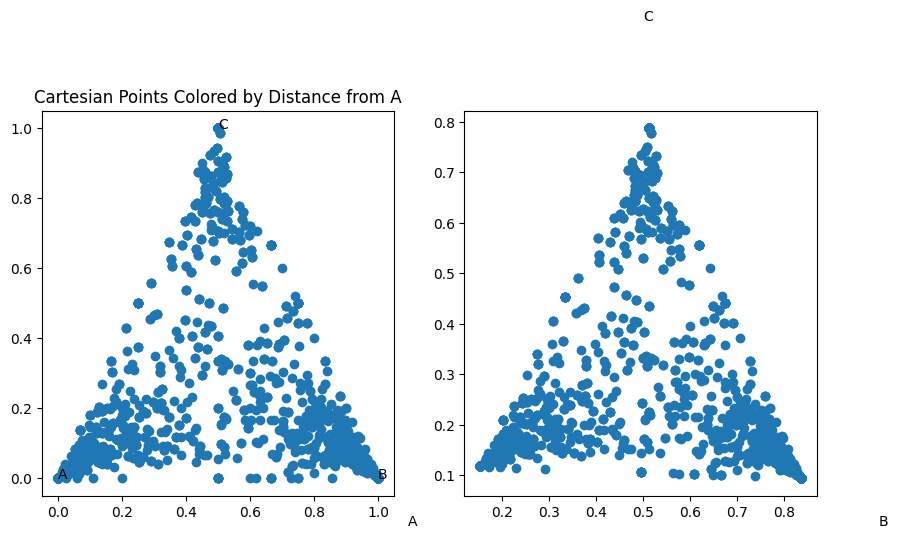

In [439]:
import matplotlib.pyplot as plt

# plot cartesian_point and approximate_translation_cartesian_point side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot cartesian_point
ax1.scatter(merged['cartesian_point'].apply(lambda x: x[0]), merged['cartesian_point'].apply(lambda x: x[1]))
ax1.text(0, 0, 'A')
ax1.text(1, 0, 'B')
ax1.text(0.5, 1, 'C')

# title
ax1.set_title('Cartesian Points Colored by Distance from A')

# plot approximate_translation_cartesian_point
ax2.scatter(merged['approximate_translation_cartesian_point'].apply(lambda x: x[0]), merged['approximate_translation_cartesian_point'].apply(lambda x: x[1]))
ax2.text(0, 0, 'A')
ax2.text(1, 0, 'B')
ax2.text(0.5, 1, 'C')



Text(0.5, 1.0, 'approximate_translation_f1 vs approximate_translation_f2')

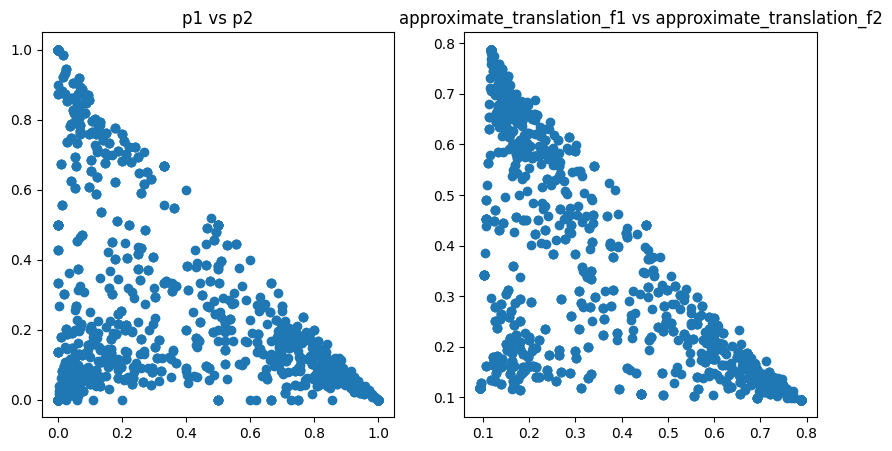

In [438]:
# plot p1 vs p2 and approximate_translation_f1 vs approximate_translation_f2 side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot p1 vs p2
ax1.scatter(merged['p1'], merged['p2'])

# title
ax1.set_title('p1 vs p2')

# plot approximate_translation_f1 vs approximate_translation_f2
ax2.scatter(merged['approximate_translation_f1'], merged['approximate_translation_f2'])

# title
ax2.set_title('approximate_translation_f1 vs approximate_translation_f2')



In [440]:
merged['approximate_translation_f1'].sum() / merged[['approximate_translation_f1', 'approximate_translation_f2', 'approximate_translation_f3']].sum().sum()

0.3492871456656782

In [442]:
merged['approximate_translation_f2'].sum() / merged[['approximate_translation_f1', 'approximate_translation_f2', 'approximate_translation_f3']].sum().sum()

0.34174678040437717

In [441]:
merged['approximate_translation_f3'].sum() / merged[['approximate_translation_f1', 'approximate_translation_f2', 'approximate_translation_f3']].sum().sum()

0.3089660739299447

In [443]:
merged['p1'].sum() / merged[['p1', 'p2', 'p3']].sum().sum()

0.3466853193528615

In [445]:
merged['p2'].sum() / merged[['p1', 'p2', 'p3']].sum().sum()

0.29738937119092457

In [444]:
merged['p3'].sum() / merged[['p1', 'p2', 'p3']].sum().sum()

0.355925309456214

In [ ]:
# plot cartesian points colored by distance from A and label A, B and C
plt.scatter(merged['cartesian_point'].apply(lambda x: x[0]), merged['cartesian_point'].apply(lambda x: x[1]), c=merged['distance_from_A'])
plt.text(0, 0, 'A')
plt.text(1, 0, 'B')
plt.text(0.5, 1, 'C')

# title
plt.title('Cartesian Points Colored by Distance from A')

In [ ]:
# cluster based on cartesian points

# split cartesian points into x and y
merged['cartesian_point_x'] = merged['cartesian_point'].apply(lambda x: x[0])
merged['cartesian_point_y'] = merged['cartesian_point'].apply(lambda x: x[1])

kmeans = KMeans(n_clusters=3, random_state=0).fit(merged[['cartesian_point_x', 'cartesian_point_y']])
merged['kmeans_cluster_cart'] = kmeans.labels_

In [ ]:
# plot cartesian points colored by kmeans cluster
plt.scatter(merged['cartesian_point_x'], merged['cartesian_point_y'], c=merged['kmeans_cluster_cart'])


In [ ]:
def process_transcripts(df, num_transcripts, k):
    transcript_ids = df['transcript_id'].value_counts().index.tolist()
    merged = pd.DataFrame()

    for transcript_id in transcript_ids[:num_transcripts]:
        profile_df = create_profile_df(df, transcript_id)
        proportion = proportion_of_kmer(profile_df, k=k)
        proportion_df = pd.DataFrame(proportion, columns=['count', 'p1', 'p2', 'p3'])
        proportion_df['transcript_id'] = transcript_id
        merged = pd.concat([merged, proportion_df])

    merged['cartesian_point'] = merged.apply(lambda x: get_cart_point(x.values[0:3]), axis=1)
    merged['cartesian_point_x'] = merged['cartesian_point'].apply(lambda x: x[0])
    merged['cartesian_point_y'] = merged['cartesian_point'].apply(lambda x: x[1])

    kmeans = KMeans(n_clusters=3, random_state=0).fit(merged[['cartesian_point_x', 'cartesian_point_y']])
    merged['kmeans_cluster_cart'] = kmeans.labels_
    
    return merged

# Plot frame breakdown per transcript

In [ ]:
import matplotlib.pyplot as plt

k_values = [3, 6, 9, 12, 15]
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    merged = process_transcripts(df, 10, k=k)
    ax = axes[i]
    
    sc = ax.scatter(merged['cartesian_point_x'], merged['cartesian_point_y'], c=merged['kmeans_cluster_cart'])
    ax.set_title('k = {}'.format(k))
    

# legend
fig.legend(*sc.legend_elements(), loc="lower left", title="Classes")
plt.show()

# Plot Ribosome Profile

In [ ]:


def plot_profile(profile_df, transcript_id):
    # get profile df for transcript
    profile_df = create_profile_df(df, transcript_id)
    

    frame1 = profile_df[profile_df['a_site'] % 3 == 0]
    frame2 = profile_df[profile_df['a_site'] % 3 == 1]
    frame3 = profile_df[profile_df['a_site'] % 3 == 2]
    # plot with plotly
    import plotly.graph_objects as go

    fig = go.Figure()

    fig.add_trace(go.Bar(x=frame1['a_site'], y=frame1['count'], name='frame1'))
    fig.add_trace(go.Bar(x=frame2['a_site'], y=frame2['count'], name='frame2'))
    fig.add_trace(go.Bar(x=frame3['a_site'], y=frame3['count'], name='frame3'))

    # label axes
    fig.update_xaxes(title_text='a_site')
    fig.update_yaxes(title_text='count')

    # title
    fig.update_layout(title_text=f'Ribosome Profile of {transcript_id}')

    fig.show()



In [ ]:
plot_profile(profile_df, transcript_id)

# Sliding window periodicity Triangle per gene

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming you have defined the required functions (e.g., create_profile_df, proportion_of_kmer, get_cart_point) earlier in your code.

# Number of subplots to create

def plot_periodicity_triangles(df, k=9, size=50, step=25, transcript_id=None):

    if not transcript_id:
        transcript_id = df['transcript_id'].value_counts().index.tolist()[20]

    # Get profile df for transcript
    profile_df = create_profile_df(df, transcript_id)

    # Get end of transcript
    end = profile_df[profile_df['count'] > 1]['a_site'].max()
    start = 0

    windows = []
    for i in range(start, end - size, step):
        windows.append([i, i + size])

    print(f"Generating {len(windows)} plots")
    # Create subplots in a grid
    num_rows = round(np.sqrt(len(windows))) + 1
    num_cols = round(np.sqrt(len(windows))) + 1

    # Create subplots with shared axes
    fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[f"{window[0]}-{window[1]}" for window in windows])

    # Initialize a list to keep track of created subplots
    subplots_created = 0

    # Create a subplot for each window
    for i, window in enumerate(windows):
        # Subset proportion_df to have rows indexed by window
        subset_df = profile_df[(profile_df['a_site'] > window[0]) & (profile_df['a_site'] < window[1])]

        proportion_df = proportion_of_kmer(subset_df, k=k)
        proportion_df = pd.DataFrame(proportion_df, columns=['count', 'p1', 'p2', 'p3'])
        proportion_df['transcript_id'] = transcript_id

        proportion_df['cartesian_point'] = proportion_df.apply(lambda x: get_cart_point(x.values[1:4]), axis=1)
        proportion_df['cartesian_point_x'] = proportion_df['cartesian_point'].apply(lambda x: x[0])
        proportion_df['cartesian_point_y'] = proportion_df['cartesian_point'].apply(lambda x: x[1])

        # Create a scatter plot using Plotly
        scatter = go.Scatter(
            x=proportion_df['cartesian_point_x'],
            y=proportion_df['cartesian_point_y'],
            mode='markers',
            marker=dict(
                size=10,
                opacity=0.6,
                color=proportion_df['count'],
                colorscale='Viridis',
            ),
            name=f'{window}',
        )

        # Add the subplot to the grid
        row = subplots_created // num_cols + 1
        col = subplots_created % num_cols + 1
        fig.add_trace(scatter, row=row, col=col)
        triangle = go.Scatter(
            x=[0, 1, 0.5, 0],
            y=[0, 0, 1, 0],  # Adjust the y-values as needed
            mode='lines+text',
            line=dict(color='red', width=2),
            text=['', '', '', ''],
        )
        fig.add_trace(triangle, row=row, col=col)

        subplots_created += 1

        # if subplots_created >= num_plots:
        #     break

    # Update layout and display the grid of plots
    fig.update_layout(
        title=f'Proportion of Reads in Each Frame for {k} nt Window - Transcript {transcript_id}',
        showlegend=False,
        width=1200,
        height=800,
    )


    fig.show()



In [ ]:
plot_periodicity_triangles(df, k=9, size=200, step=100, transcript_id="ENST00000369535")
plot_profile(profile_df, "ENST00000369535")

# Exploring Distances on Cartesian

In [ ]:
metagene_proportions = [0.7, 0.2, 0.1]
codon_proportions = [0.5, 0.4, 0.1]


# plot metagene proportions as bar plot color red, green, blue and have Y axis go up to 1
plt.bar([0, 1, 2], metagene_proportions, color=['red', 'green', 'blue'])

In [ ]:
import plotly.express as px
import numpy as np

# Initialize data dictionary
data = {'x': [], 'y': []}

# get vertices of triangle
vertices = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, 1]])

# Iterate through metagene proportions
for _ in range(len(metagene_proportions)):
    cartesian_point = np.dot(metagene_proportions, vertices)
    data['x'].append(cartesian_point[0])
    data['y'].append(cartesian_point[1])

    # Cycle to the next metagene by shifting the proportions
    metagene_proportions = [metagene_proportions[-1]] + metagene_proportions[:-1]

# Create a scatter plot of the data points
fig = px.scatter(data, x='x', y='y', width=800, height=800)

# Add a trace for the triangle
triangle = go.Scatter(
    x=[0, 1, 0.5, 0],
    y=[0, 0, 1, 0],  # Adjust the y-values as needed
    mode='lines+text',
    line=dict(color='red', width=2),
    text=['', '', '', ''],
)
fig.add_trace(triangle)
# Show the plot

print(list(zip(data['x'], data['y'])))

# plot codon proporiton as cartesian point
cartesian_point = np.dot(codon_proportions, vertices)

fig.add_trace(go.Scatter(x=[cartesian_point[0]], y=[cartesian_point[1]], mode='markers', marker=dict(size=10, color='red')))
fig.show()


In [ ]:
reference_points_lst = list(zip(data['x'], data['y']))

reference_points = {
    'Frame1': reference_points_lst[0],
    'Frame2': reference_points_lst[1],
    'Frame3': reference_points_lst[2],
}
# get distance from reference points to cartesian point
distances = []
for reference_point in reference_points.values():
    print(reference_point, calculate_distance_cartesian(cartesian_point, reference_point))
    distances.append(calculate_distance_cartesian(cartesian_point, reference_point))

# get closest reference point
closest_reference_point = list(reference_points.keys())[np.argmin(distances)]
closest_reference_point

# Potential Metrics: 1 - (distance from closest reference point / distance from equidistance point)

In [ ]:
#get point equidistant from all reference points
equidistant_point = np.mean(reference_points_lst, axis=0)

# get distance from equidistant point to reference points
max_distance = calculate_distance_cartesian(equidistant_point, reference_points['Frame1'])

# get distance from cartesian point to closest reference point
cart_distance = calculate_distance_cartesian(cartesian_point, reference_points[closest_reference_point])

inverse_proportion_distance_to_equidistant = 1 - (cart_distance / max_distance)
inverse_proportion_distance_to_equidistant

In [ ]:
# plot lines from cart point to equidistant point and reference points
fig.add_trace(go.Scatter(x=[equidistant_point[0], cartesian_point[0]], y=[equidistant_point[1], cartesian_point[1]], mode='lines', line=dict(color='black', width=2)))

#label each line with distance
fig.add_trace(go.Scatter(x=[equidistant_point[0], cartesian_point[0]], y=[equidistant_point[1], cartesian_point[1]], mode='text', text=[round(max_distance,2), round(cart_distance, 2)], textposition='top center'))

fig.add_trace(go.Scatter(x=[cartesian_point[0], reference_points[closest_reference_point][0]], y=[cartesian_point[1], reference_points[closest_reference_point][1]], mode='lines', line=dict(color='black', width=2)))

# Potential Metrics: 1 - (distance from closest reference point / sum of distances from all reference points)

In [ ]:
closest_over_sum = 1 - (cart_distance / (sum(distances)))
closest_over_sum